# OCAA Scraper by Julián Restrepo

In this project I will create a scraper bot that will gather data from the Ontario College Athletic Association (OCAA).

OCAA Website: https://www.ocaa.com/landing/index

Data to gather:
1. Results of matches from the Men's Basketball league in Ontario Colleges.
2. Individual information of perfomance of each player in each match.

The data is goint to be send to Pandas and MS Excel. This to allow people with no programming knowledge to use the data.

In [4]:
### Importing Libraries ###

from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re
import time
from openpyxl import load_workbook

In [5]:
### Requesting Data, Formatting Data and assigning Data ###

links = ["https://www.ocaa.com/sports/mbkb/2021-22/schedule"]

# Links Variables:
base_link = "https://www.ocaa.com/"
base_link_player_info = "https://www.ocaa.com/sports/mbkb/2021-22"

# Lists:
matches_list = []
boxscores_links_list = []
players_list = []

print("Starting Process...")
print()

for link in links:
    
    # Request
    r = requests.get(link, headers={'User-Agent': 'Mozilla/5.0'})
    sport_soup = bs(r.content)
    
    # Getting all links of matches 
    boxscores_links_all = sport_soup.find_all('a', attrs={'class':'link'})
    
    # Box Score filter
    for boxscore_link in boxscores_links_all:
        if boxscore_link.text == "Box Score":
            boxscores_links_list.append(boxscore_link['href'])

for boxscore_link in boxscores_links_list:
    start = time.time()
    
    match = {}

    # Request
    link = base_link + boxscore_link
    r = requests.get(link, headers={'User-Agent': 'Mozilla/5.0'})
    box_soup = bs(r.content)

    # Game Information
    div_game_info = box_soup.find('div', attrs={'class':'game-info'})
    td_game_info = div_game_info.find_all('td', attrs={'text'})
    
    # Assign Data
    match['Date'] = td_game_info[0].text
    match['Location'] = td_game_info[1].text
    match['Officials'] = td_game_info[3].text.split(',')
    match['Link'] = link
    match['Team 1 Points'] = int(box_soup.find('div', attrs={'class':'team-score visitor'}).text)
    match['Team 2 Points'] = int(box_soup.find('div', attrs={'class':'team-score home'}).text)
    
    # ¿Who Won?
    if match['Team 1 Points'] > match['Team 2 Points']:
        match['Winner'] = "Team 1"
    elif match['Team 1 Points'] < match['Team 2 Points']:
        match['Winner'] = "Team 2"
    
    # Data Cleaning: Removing white spaces of names of Officials
    for i in range(len(match['Officials'])):
        match['Officials'][i] = match['Officials'][i].strip()
    
    # Team Names
    span_visitor_team = box_soup.find_all('span', attrs={'class':'team-name'})[:2]
    teams_names = [span_visitor_team[0].text, span_visitor_team[1].text]
    match['Team 1'] = match['Visitor'] = teams_names[0]
    match['Team 2'] = match['Host'] = teams_names[1]
    
    # Gettin players Info
    div_info = box_soup.find('div', attrs={'class':'tab-container primary clearfix'})
    div_players_visitor = div_info.find('div', attrs={'class':'stats-box full lineup visitor clearfix'})
    div_players_host = div_info.find('div', attrs={'class':'stats-box full lineup home clearfix'})
    tbody_players_visitor = div_players_visitor.select('tbody tr')
    tbody_players_host = div_players_host.select('tbody tr')
    
    tbodys_list = [tbody_players_visitor, tbody_players_host]
    for tbody in tbodys_list:
        for tr in tbody:
            if tr.has_attr('class'):
                tbody.remove(tr)
    
    players_visitor_info = tbodys_list[0][:-2]
    players_host_info = tbodys_list[1][:-2]
    
    all_players = [players_visitor_info, players_host_info]
    
    for team_players_info in all_players:
        
        for player in team_players_info:

            player_info = {}
            player_points = []
            
            try:
                player_info['Name'] = player.find('a', attrs={'class':'player-name'}).text
                player_info['Link'] = base_link_player_info + player.find('a', attrs={'class':'player-name'})['href'].replace('..', '')
            except:
                player_info['Name'] = player.find('span', attrs={'class':'player-name'}).text
                player_info['Link'] = "N/A"
                
            if all_players.index(team_players_info) == 0:
                player_info['Team'] = match['Visitor']
            elif all_players.index(team_players_info) == 1:
                player_info['Team'] = match['Host']
                
            points_player_td = player.find_all('td')

            for point_td in points_player_td:
                player_points.append(point_td.text.replace(" ", "").replace("\n", ""))

            # PLayer Points
            player_info['MIN'] = int(player_points[0])
            player_info['FGM'] = int(player_points[1].split('-')[0])
            player_info['FGMA'] = int(player_points[1].split('-')[1])
            player_info['3PM'] = int(player_points[2].split('-')[0])
            player_info['3PMA'] = int(player_points[2].split('-')[1])
            player_info['FTM'] = int(player_points[3].split('-')[0])
            player_info['FTMA'] = int(player_points[3].split('-')[1])
            player_info['PTS'] = int(player_points[12])

           # Appending players information to database
            players_list.append(player_info)
            end = time.time()
    
    matches_list.append(match)
    
    # Printing Process
    print()
    print("#"*100)
    print("Data Obtained...")
    print(boxscore_link)
    print(match['Visitor'], "-", match['Host'])
    print(match['Date'])
    print("#"*100)
    print()
    
# Printing Final Results:
print()
print()
print("Process Finished!")
print("Matches Data Collected: ", len(matches_list))
print()
print()

Starting Process...


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220209_61z4.xml
Centennial - Georgian
February 9, 2022  - 7:00 PM 
####################################################################################################


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220209_bqwc.xml
Mohawk - Humber
February 9, 2022  - 8:00 PM 
####################################################################################################


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220209_0lfj.xml
Lambton - St. Clair
February 9, 2022  - 8:00 PM 
####################################################################################################


#######################


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220218_wh6j.xml
Seneca - Durham
February 18, 2022  - 8:00 PM 
####################################################################################################


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220218_k4oh.xml
George Brown - Centennial
February 18, 2022  - 8:00 PM 
####################################################################################################


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220218_c8ak.xml
Canadore - Redeemer
February 18, 2022  - 8:00 PM 
####################################################################################################


#####################################


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220226_3v6z.xml
Redeemer - Humber
February 26, 2022  - 3:00 PM 
####################################################################################################


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220227_58nr.xml
Georgian - Loyalist
February 27, 2022  - 1:00 PM 
####################################################################################################


####################################################################################################
Data Obtained...
/sports/mbkb/2021-22/boxscores/20220227_93hd.xml
Lambton - Niagara
February 27, 2022  - 3:00 PM 
####################################################################################################


###########################################

### Creating Pandas Dataframe

In [6]:
### Pandas Creation ###

# Players
players_database = pd.DataFrame(players_list)
players_database['GP'] = 0

# Grouping Players by Name
d = { 'Team': 'first','Link': 'first','GP':'count', 'MIN': 'sum', 'FGM': 'sum', 'FGMA': 'sum', '3PM': 'sum', '3PMA': 'sum', 'FTM': 'sum', 'FTMA': 'sum', 'PTS': 'sum'}
players_database = players_database.groupby('Name', as_index=False).aggregate(d).reindex(columns=players_database.columns)

# Matches
matches_database = pd.DataFrame(matches_list)

#### Summary of matches Dataframe

In [11]:
matches_database.head()

,Date,Location,Officials,Link,Team 1 Points,Team 2 Points,Winner,Team 1,Visitor,Team 2,Host
0,"February 9, 2022 - 7:00 PM",Georgian,"[Nicholas Borich, Dez Collins, Robert Roy]",https://www.ocaa.com//sports/mbkb/2021-22/boxs...,74,81,Team 2,Centennial,Centennial,Georgian,Georgian
1,"February 9, 2022 - 8:00 PM",Humber Athletics Centre,"[, , ]",https://www.ocaa.com//sports/mbkb/2021-22/boxs...,79,113,Team 2,Mohawk,Mohawk,Humber,Humber
2,"February 9, 2022 - 8:00 PM",St. Clair College Sportsplex,"[, , ]",https://www.ocaa.com//sports/mbkb/2021-22/boxs...,79,94,Team 2,Lambton,Lambton,St. Clair,St. Clair
3,"February 9, 2022 - 8:00 PM",Fanshawe College,"[, , ]",https://www.ocaa.com//sports/mbkb/2021-22/boxs...,70,115,Team 2,Conestoga,Conestoga,Fanshawe,Fanshawe
4,"February 10, 2022 - 8:00 PM",Sheridan,"[, , ]",https://www.ocaa.com//sports/mbkb/2021-22/boxs...,85,91,Team 2,Redeemer,Redeemer,Sheridan,Sheridan


#### Summary of players Dataframe


In [12]:
players_database.head()

,Name,Link,Team,MIN,FGM,FGMA,3PM,3PMA,FTM,FTMA,PTS,GP
0,Abdek Farah,https://www.ocaa.com/sports/mbkb/2021-22/playe...,Canadore,116,15,42,8,17,10,10,48,4
1,Abdul Majid,https://www.ocaa.com/sports/mbkb/2021-22/playe...,St. Lawrence,218,44,101,8,28,50,63,146,6
2,Abdullah Sheikh,https://www.ocaa.com/sports/mbkb/2021-22/playe...,St. Lawrence,38,6,11,1,3,5,8,18,5
3,Adam Hosseini,https://www.ocaa.com/sports/mbkb/2021-22/playe...,Durham,186,50,107,20,64,15,21,135,7
4,Adam Kislinsky,https://www.ocaa.com/sports/mbkb/2021-22/playe...,Lambton,5,1,1,0,0,0,0,2,5


### Creating the connection to the MS Excel workbook

You can check out the MS Excel in the folder as "OCAA Database"

In [7]:
### Excel Creation ###

file_name = "OCAA Database Template.xlsx"

# Adding players data to Excel
wb = load_workbook(file_name)
sheet = wb['Players Database']

for i in range(len(players_database)):
    sheet.cell(row=5+i , column= 2, value=players_database['Name'][i])
    sheet.cell(row=5+i , column= 3, value=players_database['Team'][i])
    sheet.cell(row=5+i , column= 4, value=players_database['Link'][i])
    sheet.cell(row=5+i , column= 5, value=players_database['GP'][i])
    sheet.cell(row=5+i , column= 6, value=players_database['MIN'][i])
    sheet.cell(row=5+i , column= 7, value=players_database['FGM'][i])
    sheet.cell(row=5+i , column= 8, value=players_database['FGMA'][i])
    sheet.cell(row=5+i , column= 9, value=players_database['3PM'][i])
    sheet.cell(row=5+i , column= 10, value=players_database['3PMA'][i])
    sheet.cell(row=5+i , column= 11, value=players_database['FTM'][i])
    sheet.cell(row=5+i , column= 12, value=players_database['FTMA'][i])
    sheet.cell(row=5+i , column= 13, value=players_database['PTS'][i])
    

# Adding matches data to Excel:
sheet = wb['Matches Database']

for i in range(len(matches_database)):
    sheet.cell(row=5+i , column= 2, value=matches_database['Date'][i])
    sheet.cell(row=5+i , column= 3, value=matches_database['Team 1'][i])
    sheet.cell(row=5+i , column= 4, value=matches_database['Team 2'][i])
    sheet.cell(row=5+i , column= 5, value=matches_database['Host'][i])
    sheet.cell(row=5+i , column= 6, value=matches_database['Location'][i])
    sheet.cell(row=5+i , column= 7, value=matches_database['Link'][i])
    sheet.cell(row=5+i , column= 8, value=matches_database['Team 1 Points'][i])
    sheet.cell(row=5+i , column= 9, value=matches_database['Team 2 Points'][i])
    sheet.cell(row=5+i , column= 10, value=matches_database['Winner'][i])
    
# Saving Completed Excel.
wb.save('OCAA Database.xlsx')

 #### TOP 5 Players with most points:

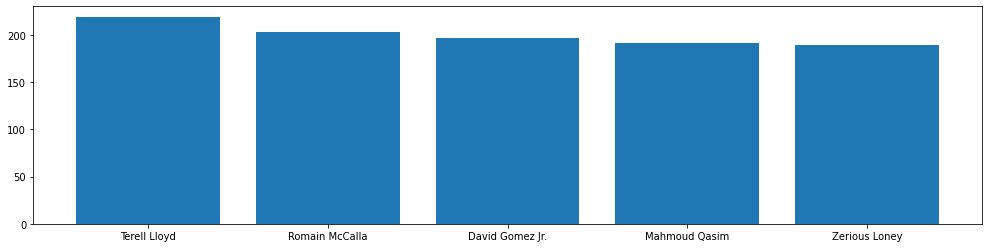

In [34]:
plt.figure(figsize=(17,4))
plt.bar(players_database.sort_values('PTS', ascending=False)[0:5]['Name'], players_database.sort_values("PTS", ascending=False)[0:5]['PTS'])
plt.show()

### Clonclusion

The information from all matches and all players was storaged in the MS Excel "OCAA Database"

Which are some questions can we answer with this data collected?

1. Who is the best 3 point shooter in the rival team?
2. Which players in the rival team are not efficient with X type of shooting?
3. Which players should we focus on shadowing?
4. Which teams are doing better? What type of strategy are they using?

These are some of the questions that this dataset can answer.
